In [16]:
import tensorflow as tf 
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns 

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM
#from tensorflow.keras.optimizers import SGD
from tensorflow.keras import regularizers
from keras.layers import CuDNNLSTM

In [17]:
data = pd.read_csv("undersampled_cic.csv")
data.head()

,Flow Duration,Tot Fwd Pkts,Tot Bwd Pkts,TotLen Fwd Pkts,TotLen Bwd Pkts,Fwd Pkt Len Max,Fwd Pkt Len Min,Fwd Pkt Len Mean,Fwd Pkt Len Std,Bwd Pkt Len Max,...,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,protocol__0,protocol__6,protocol__17,target
0,551,2,0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,...,0.0,0.0,0.000000e+00,0.000000,0.0,0.0,0,1,0,3
1,112638867,3,0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,...,0.0,0.0,5.631943e+07,1679.378605,56320621.0,56318246.0,1,0,0,3
2,8966,3,4,326.0,129.0,326.0,0.0,108.666667,188.216188,112.0,...,0.0,0.0,0.000000e+00,0.000000,0.0,0.0,0,1,0,5
3,111816159,17,23,2872.0,1709.0,1460.0,0.0,168.941176,474.948217,428.0,...,578105.0,63064.0,9.999056e+06,23491.769152,10014914.0,9952970.0,0,1,0,0
4,369756,22,22,1976.0,2665.0,640.0,0.0,89.818182,138.033687,976.0,...,0.0,0.0,0.000000e+00,0.000000,0.0,0.0,0,1,0,1


In [18]:
X = data.drop("target",axis=1).values
y = data["target"].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# One hot encode the y values 
#y_train = pd.get_dummies(y_train).values
#y_test = pd.get_dummies(y_test).values

# Scale X values 
min_max_scaler = MinMaxScaler()
X_train = min_max_scaler.fit_transform(X_train)
X_test = min_max_scaler.transform(X_test)

# Add time dimension
X_train = X_train.reshape(-1, 1, 79)
X_test  = X_test.reshape(-1, 1, 79)
#y_train = y_train.reshape(-1, 1, len(y_train))
#y_test = y_test.reshape(-1, 1, len(y_test))

In [22]:
X_train.shape

(4545, 1, 79)

In [27]:
model = Sequential()

model.add(CuDNNLSTM(128, input_shape = (1,79), return_sequences=True))
#model.add(Dropout(0.2))

model.add(CuDNNLSTM(128))
#model.add(Dropout(0.2))

model.add(Dense(32,activation='relu'))
#model.add(Dropout(0.2))

model.add(Dense(7, activation ='softmax'))

model.compile(loss='sparse_categorical_crossentropy',
             optimizer = 'adam',
             metrics = ['accuracy'])

In [28]:
model.fit(x = X_train, y = y_train, epochs = 50, batch_size = 256, verbose = 1, validation_data = (X_test,y_test))

Epoch 1/50
 1/18 [>.............................] - ETA: 8s - loss: 1.9452 - accuracy: 0.2461

2021-08-23 19:50:44.258414: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


18/18 [==============================] - 1s 30ms/step - loss: 1.9280 - accuracy: 0.3707 - val_loss: 1.8992 - val_accuracy: 0.4245
Epoch 2/50
 4/18 [=====>........................] - ETA: 0s - loss: 1.8894 - accuracy: 0.4189

2021-08-23 19:50:44.791086: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


18/18 [==============================] - 0s 22ms/step - loss: 1.8441 - accuracy: 0.4240 - val_loss: 1.7418 - val_accuracy: 0.4964
Epoch 3/50
18/18 [==============================] - 0s 22ms/step - loss: 1.5928 - accuracy: 0.4768 - val_loss: 1.3937 - val_accuracy: 0.5293
Epoch 4/50
18/18 [==============================] - 0s 22ms/step - loss: 1.2693 - accuracy: 0.5287 - val_loss: 1.0987 - val_accuracy: 0.5847
Epoch 5/50
18/18 [==============================] - 0s 22ms/step - loss: 1.0193 - accuracy: 0.6147 - val_loss: 0.8701 - val_accuracy: 0.6458
Epoch 6/50
18/18 [==============================] - 0s 22ms/step - loss: 0.8381 - accuracy: 0.7124 - val_loss: 0.7255 - val_accuracy: 0.7618
Epoch 7/50
18/18 [==============================] - 0s 22ms/step - loss: 0.7175 - accuracy: 0.7479 - val_loss: 0.6314 - val_accuracy: 0.7731
Epoch 8/50
18/18 [==============================] - 0s 22ms/step - loss: 0.6350 - accuracy: 0.7657 - val_loss: 0.5565 - val_accuracy: 0.7757
Epoch 9/50
18/18 [======

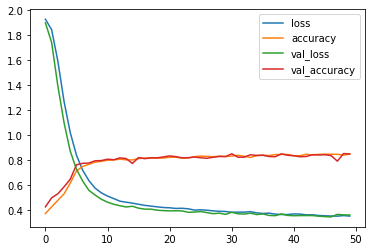

In [29]:
model_loss = pd.DataFrame(model.history.history)
model_loss.plot()
plt.show()

In [23]:
predictions = np.argmax(model.predict(X_test), axis=-1)
predictions

2021-08-23 19:49:13.849327: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


array([6, 4, 1, ..., 4, 4, 2])

In [24]:
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.65      0.33      0.44       272
           1       1.00      1.00      1.00       285
           2       0.99      1.00      0.99       288
           3       0.83      0.70      0.76       247
           4       0.56      0.71      0.63       269
           5       0.75      1.00      0.85       289
           6       0.99      1.00      1.00       298

    accuracy                           0.83      1948
   macro avg       0.82      0.82      0.81      1948
weighted avg       0.83      0.83      0.82      1948

